## import libraries 

In [1]:
# Main Modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore")
import random
random.seed(42)

# Time Series Modules
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Model Evaluation Modules
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Read the data

In [2]:
df = pd.read_csv('../data/MarketPricePrediction.csv')
print('Shape of data:',df.shape)
df.head()

Shape of data: (10227, 10)


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


## 1- Data Preprocessing
Cleaning the dataset, handling missing values, and encoding categorical variables

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10227 entries, 0 to 10226
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
 9   date      10227 non-null  object
dtypes: int64(5), object(5)
memory usage: 799.1+ KB


In [4]:
print('Sum of Missing data')
df.isna().sum()

Sum of Missing data


market      0
month       0
year        0
quantity    0
priceMin    0
priceMax    0
priceMod    0
state       0
city        0
date        0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%B-%Y')
# Set 'date' column as index
df.set_index('date', inplace=True)
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR
2006-01-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR
2010-01-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR
2011-01-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR
2012-01-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10227 entries, 2005-01-01 to 2015-12-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
dtypes: int64(5), object(4)
memory usage: 799.0+ KB


There no missing data or dublicated in our dataset!

In [8]:
# select important data
df = df.drop(['month','year','market', 'state', 'city'],axis=1)

In [9]:
# Calculate monthly mean
monthly_mean = df.resample('M').mean()

## 2- Exploratory Data Analysis

#### A- Temporal Patterns

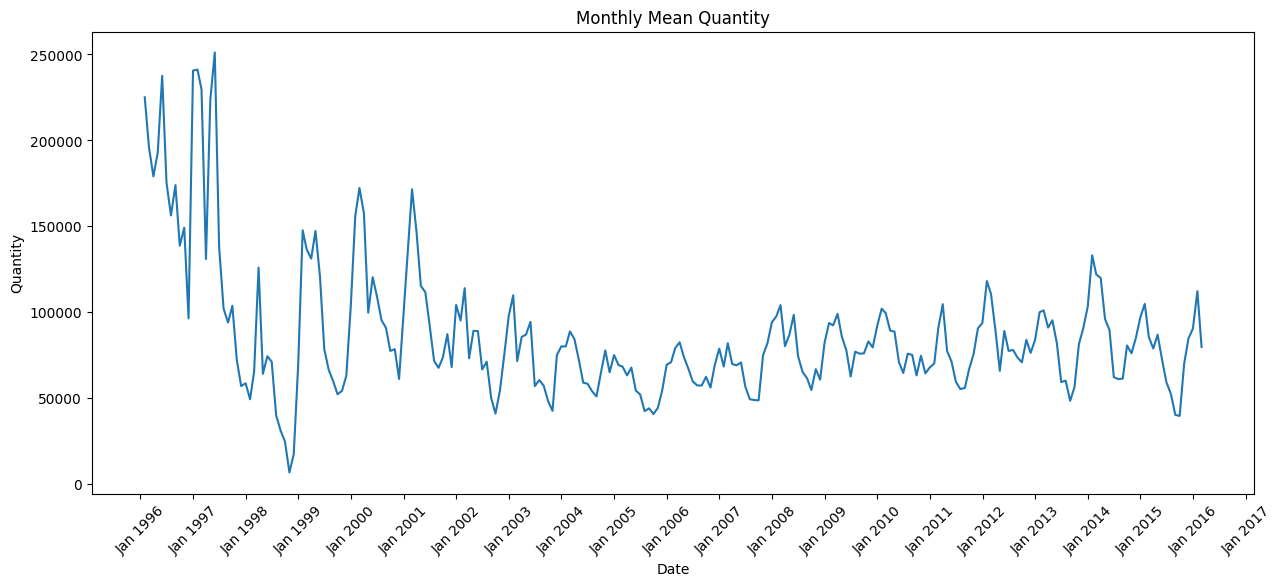

In [10]:
# Create a line plot
plt.figure(figsize=(15, 6))
plt.plot(monthly_mean.index, monthly_mean['quantity'], label='Mean quantity')

# Customize x-ticks with a monthly frequency, but display ticks annually
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

# Rotate x-tick labels
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Monthly Mean Quantity')

# Show plot
plt.show()

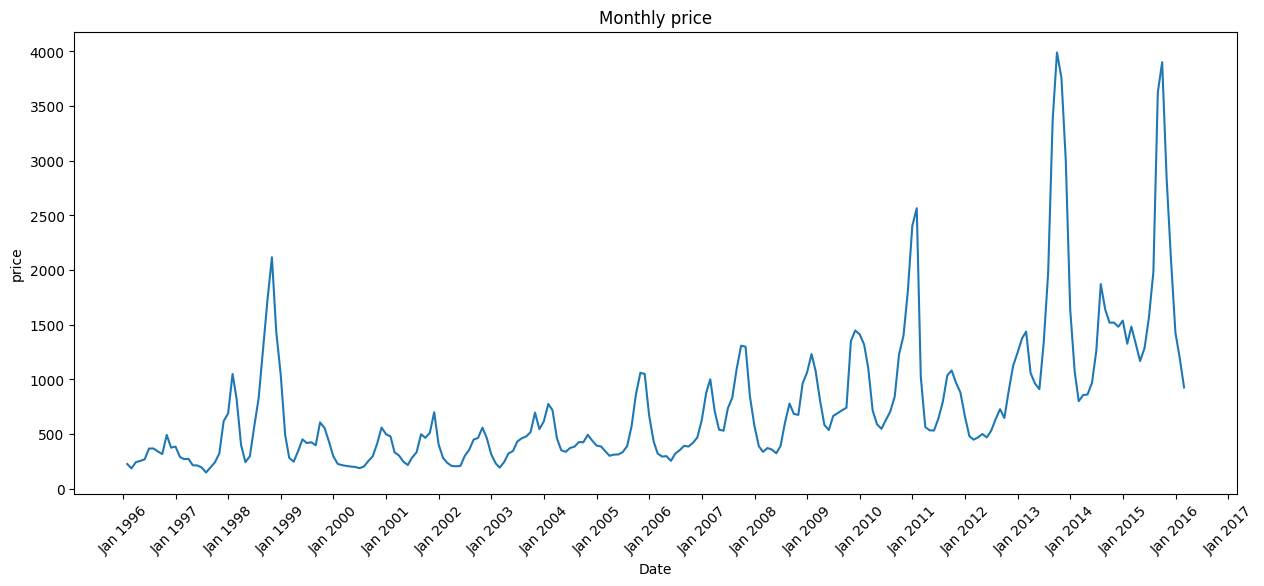

In [11]:
# Create a line plot
plt.figure(figsize=(15, 6))
plt.plot(monthly_mean.index, monthly_mean['priceMod'], label='price')

# Customize x-ticks with a monthly frequency, but display ticks annually
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

# Rotate x-tick labels
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('price')
plt.title('Monthly price')

# Show plot
plt.show()

#### B-Seasonal Decomposition

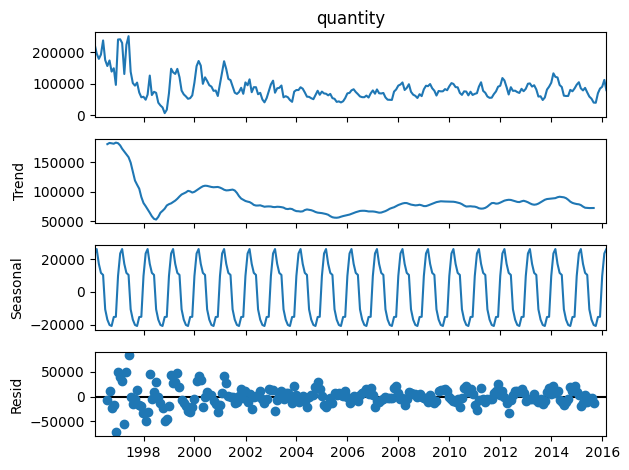

In [12]:
# plt.rcParams.update({'figure.figsize':(15,8)})
result = seasonal_decompose(monthly_mean['quantity'], model='additive')
result.plot()
plt.show()

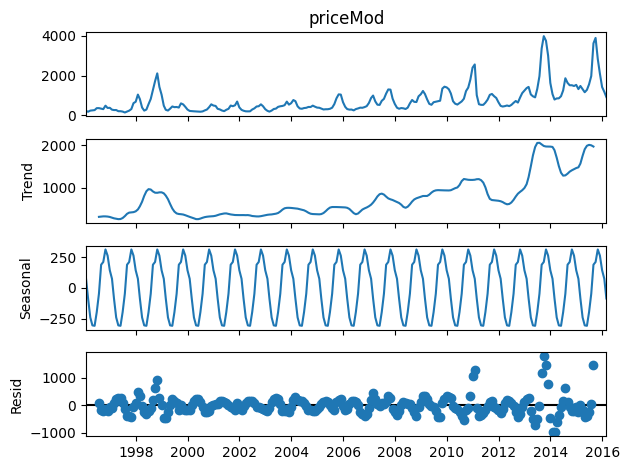

In [13]:
result2 = seasonal_decompose(monthly_mean['priceMod'], model='additive')
result2.plot()
plt.show()

### C-Monthly Seasonality
This helps in understanding how the quantity and price typically change throughout the year, revealing any seasonal patterns.

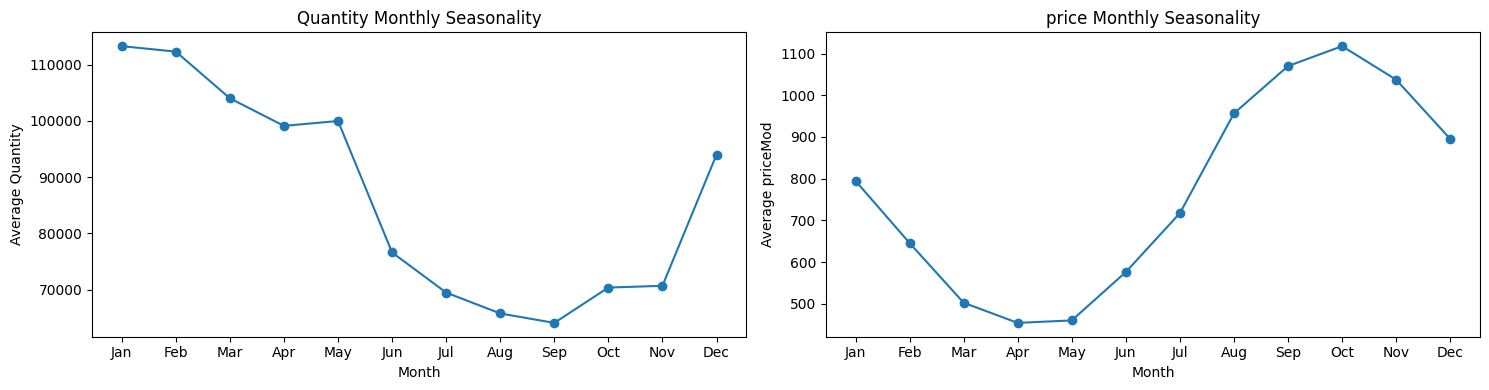

In [14]:
#The monthly_seasonality DataFrame provides a summary of the average quantity for each month across all years in dataset. 
monthly_seasonality = monthly_mean.groupby(monthly_mean.index.month).mean()
monthly_seasonality.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Plot the first graph (average quantity)
axs[0].plot(monthly_seasonality.index, monthly_seasonality['quantity'], marker='o', linestyle='-')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average Quantity')
axs[0].set_title('Quantity Monthly Seasonality')

# Plot the second graph (average priceMod)
axs[1].plot(monthly_seasonality.index, monthly_seasonality['priceMod'], marker='o', linestyle='-')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average priceMod')
axs[1].set_title('price Monthly Seasonality')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

## 3-Feature Engineering
**Rolling Statistics**

In [15]:
# rolling for quantity
monthly_mean['rollMeanQ'] = monthly_mean.quantity.rolling(window=12).mean()
monthly_mean['rollStdQ'] = monthly_mean.quantity.rolling(window=12).std()

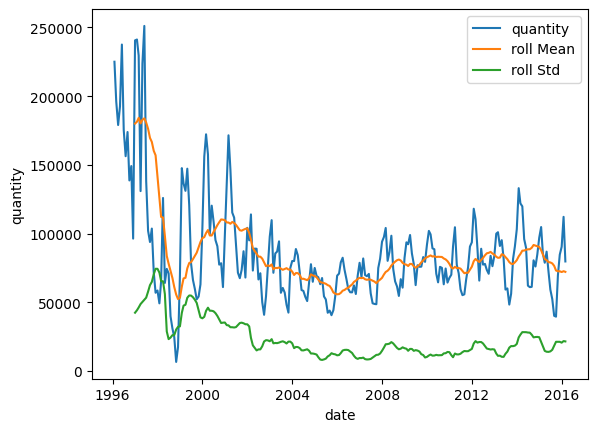

In [16]:
# plt.figure(figsize=(15,5))
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.quantity,label='quantity')
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.rollMeanQ,label='roll Mean')
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.rollStdQ,label='roll Std')
plt.legend()
plt.show()

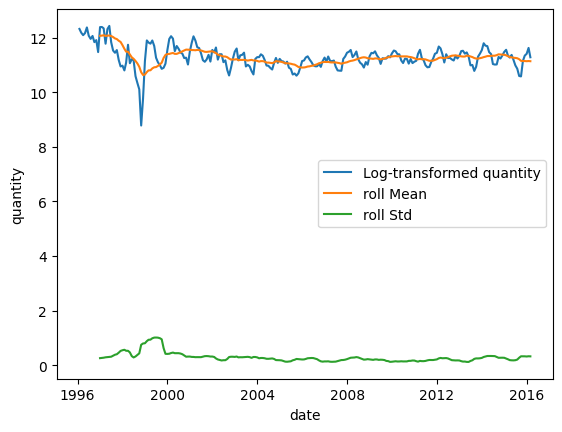

In [17]:
log_quantity = np.log(monthly_mean.quantity)
# rolling for price
monthly_mean['rollMeanQ'] =log_quantity.rolling(window=12).mean()
monthly_mean['rollStdQ'] = log_quantity.rolling(window=12).std()
# plt.figure(figsize=(15,5))
sns.lineplot(data=log_quantity,label='Log-transformed quantity')
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.rollMeanQ,label='roll Mean')
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.rollStdQ,label='roll Std')
plt.legend()
plt.show()

In [18]:
# ADF Test - null hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(log_quantity.values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {format(adfuller_result[1], ".20f")}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# log_quantity is stationary p < 0.05

ADF Statistic: -4.919117230062212
p-value: 0.00003200622184894273
Critial Values:
   1%, -3.4596204846395824
Critial Values:
   5%, -2.8744153028455948
Critial Values:
   10%, -2.5736320761218576


In [19]:
# rolling for price
monthly_mean['rollMeanP'] = monthly_mean.priceMod.rolling(window=12).mean()
monthly_mean['rollStdP'] = monthly_mean.priceMod.rolling(window=12).std()

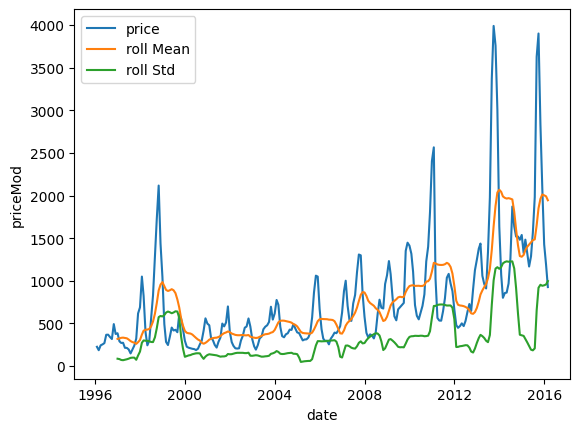

In [20]:
# plt.figure(figsize=(15,5))
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.priceMod,label='price')
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.rollMeanP,label='roll Mean')
sns.lineplot(data=monthly_mean,x=monthly_mean.index,y=monthly_mean.rollStdP,label='roll Std')

plt.legend()
plt.show()

**adfuller test for stationarity**

In [21]:
# ADF Test - null hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(monthly_mean.priceMod.values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# price is non stationary p > 0.05

ADF Statistic: -1.5529565759212156
p-value: 0.50717101597369
Critial Values:
   1%, -3.4593607492757554
Critial Values:
   5%, -2.8743015807562924
Critial Values:
   10%, -2.5735714042782396


**Stationarity transformation for price**

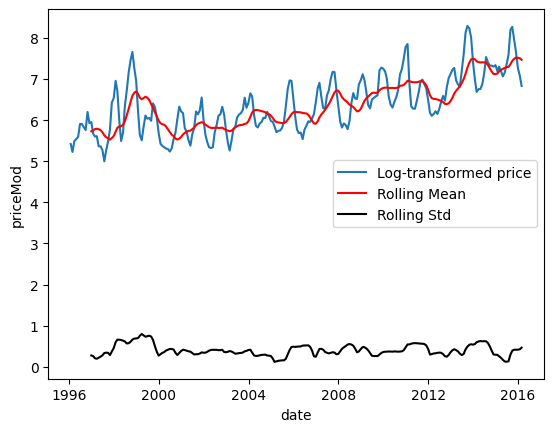

In [22]:
# log transform
log_price= np.log(monthly_mean[['priceMod']])
# plt.figure(figsize=(15, 6))
#Determing rolling statistics
rolLmean = log_price.rolling(12).mean()
rolLstd = log_price.rolling(12).std()
# Plotting
plt.plot(log_price, label='Log-transformed price')
plt.plot(rolLmean, color='red', label='Rolling Mean')
plt.plot(rolLstd, color='black', label='Rolling Std')
plt.ylabel('priceMod')
plt.xlabel('date')
plt.legend()
plt.show()

In [23]:
log_price.dropna()
adfuller_result = adfuller(log_price.values,autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {format(adfuller_result[1], ".20f")}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# price is non stationary

ADF Statistic: -2.0012700053208152
p-value: 0.28601652388250409231
Critial Values:
   1%, -3.4584868856997004
Critial Values:
   5%, -2.873918902362675
Critial Values:
   10%, -2.573367247623359


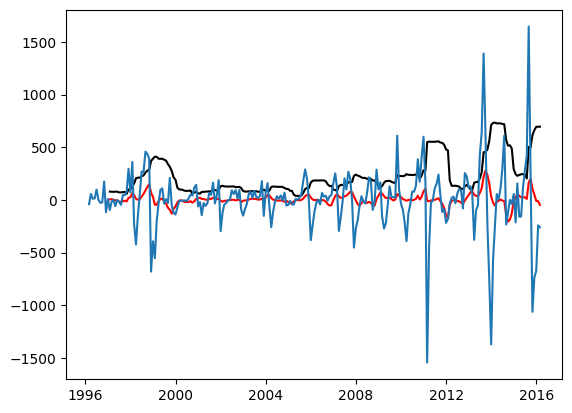

In [24]:
diff_price = monthly_mean[['priceMod']] - monthly_mean[['priceMod']].shift()
#Determing rolling statistics
rolLmean = diff_price.rolling(12).mean()
rolLstd = diff_price.rolling(12).std()
# plt.figure(figsize=(15, 6))
plt.plot(rolLmean, color='red', label='Rolling Mean')
plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.plot(diff_price)
plt.show()

In [25]:
diff_price = diff_price.dropna()

In [26]:
adfuller_result = adfuller(diff_price.values,autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {format(adfuller_result[1], ".20f")}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# price is now stationary

ADF Statistic: -5.287286994163953
p-value: 0.00000581762786323481
Critial Values:
   1%, -3.4593607492757554
Critial Values:
   5%, -2.8743015807562924
Critial Values:
   10%, -2.5735714042782396


## 4-Model Selection and Training

**Univariate Time Series**
- `seasonality is present in the data` : consider using SARIMA (Seasonal ARIMA) models to account for seasonal effects.

**SARIMA model for quantity**

In [27]:
quantity = pd.DataFrame(log_quantity.copy(deep=True))

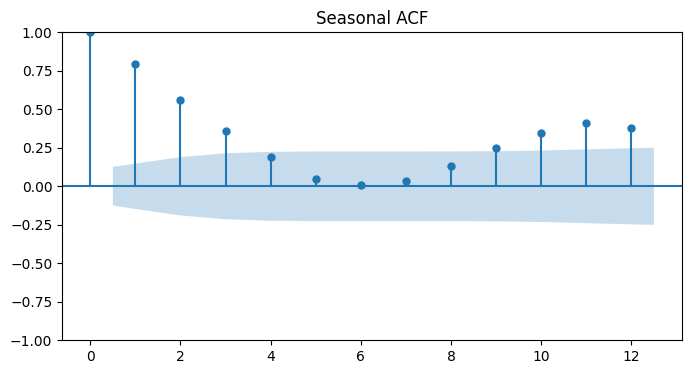

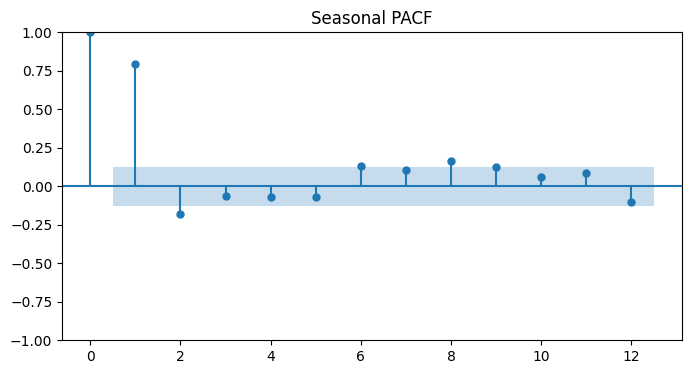

In [28]:
plt.rcParams.update({'figure.figsize':(8,4)})

plot_acf(quantity, lags=12)
plt.title('Seasonal ACF')
plt.show()

plot_pacf(quantity, lags=12)
plt.title('Seasonal PACF')
plt.show()

In [29]:
# Split the data into training and test sets
train_size = int(len(quantity) * 0.7)
train, test = quantity[:train_size], quantity[train_size:]

print(f'Training set length: {len(train)}')
print(f'Test set length: {len(test)}')

Training set length: 169
Test set length: 73


In [30]:
model= SARIMAX(train ,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12))
model_fit=model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
quantity['sarimaPred'] = prediction
quantity.tail()

,quantity,sarimaPred
date,,
2015-10-31,11.151739,11.169175
2015-11-30,11.345509,11.228356
2015-12-31,11.411654,11.486417
2016-01-31,11.627536,11.551964
2016-02-29,11.285662,11.596636


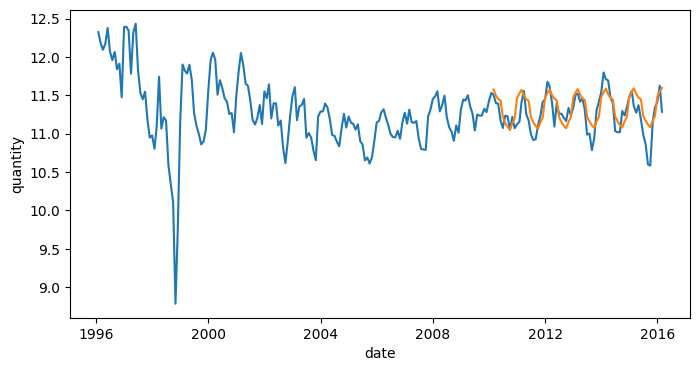

In [31]:
# plt.figure(figsize=(15,5))
sns.lineplot(data=quantity,x=quantity.index,y='quantity')
sns.lineplot(data=quantity,x=quantity.index,y='sarimaPred')
plt.show()

In [32]:
mse = mean_squared_error(test['quantity'], prediction)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(test['quantity'], prediction)
print(f'mean absoluteerror: {mae}')

# Calculate the range of the test data
test_range = test['quantity'].max() - test['quantity'].min()

# Normalize the error metrics
normalized_rmse = rmse / test_range
print(f'norm Root Mean Squared Error: {normalized_rmse}')

normalized_mae = mae / test_range
print(f'norm mean absoluteerror: {normalized_mae}')

Root Mean Squared Error: 0.18557996209034822
mean absoluteerror: 0.14861362176888682
norm Root Mean Squared Error: 0.1528010403917714
norm mean absoluteerror: 0.12236405141423479


**LSTM for quantity**

In [33]:
scaler = MinMaxScaler()

In [34]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [35]:
# Define the model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output layer for regression
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [36]:
# fit model
model.fit(generator,epochs=500)

Epoch 1/500

157/157 [==============================] - 3s 5ms/step - loss: 0.0427
Epoch 2/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0149
Epoch 3/500
157/157 [==============================] - 1s 5ms/step - loss: 0.0139
Epoch 4/500
157/157 [==============================] - 1s 5ms/step - loss: 0.0155
Epoch 5/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0153
Epoch 6/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0137
Epoch 7/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0131
Epoch 8/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0139
Epoch 9/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0145
Epoch 10/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0149
Epoch 11/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0135
Epoch 12/500
157/157 [==============================] - 1s 6ms/step - loss: 0.0136
Epoch 13/500

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
test['Predictions'] = true_predictions

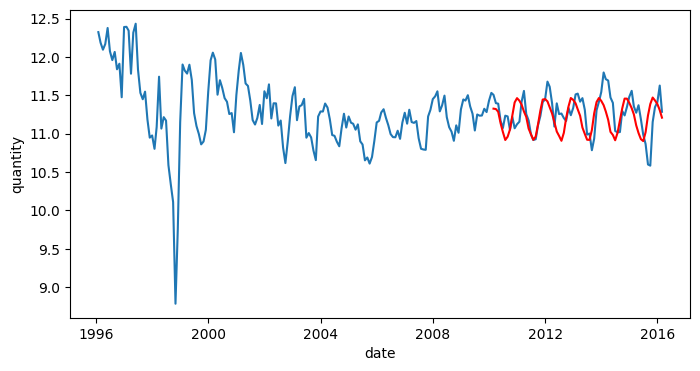

In [40]:
# plt.figure(figsize=(15,5))
sns.lineplot(data=quantity,x=quantity.index,y='quantity')
sns.lineplot(data=test,x=test.index,y='Predictions',color='red')
plt.show()

In [41]:
mse = mean_squared_error(test['quantity'], test['Predictions'])
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
# Normalize the error metrics
test_range = test['quantity'].max() - test['quantity'].min()
normalized_rmse = rmse / test_range
print(f'norm Root Mean Squared Error: {normalized_rmse}')

Root Mean Squared Error: 0.24736117181223508
norm Root Mean Squared Error: 0.20366985734718507


**SARIMA model for price**

In [42]:
price =pd.DataFrame(diff_price.copy(deep=True))

In [43]:
train_size = int(len(price) * 0.7)
train_price, test_price = price[:train_size], price[train_size:]

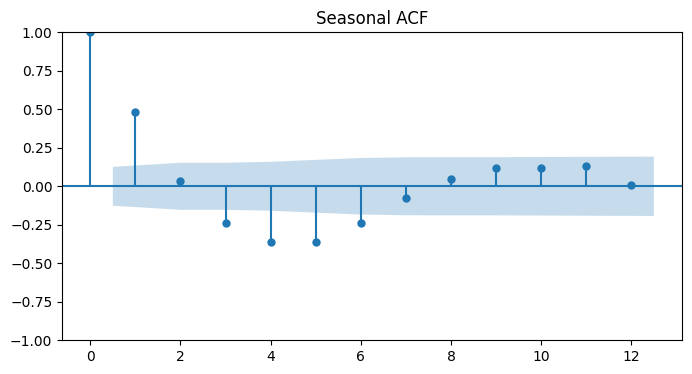

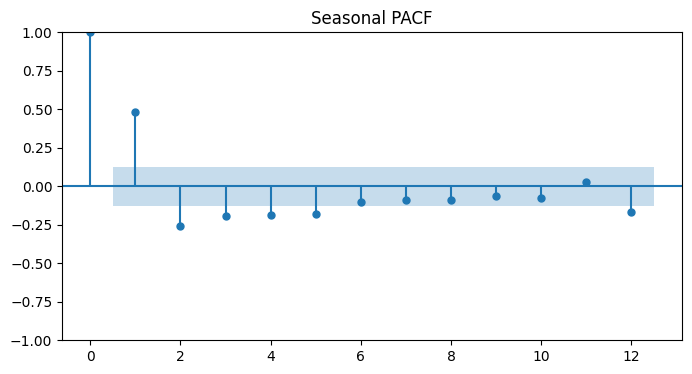

In [44]:
# Plot ACF and PACF for seasonal lags
plt.rcParams.update({'figure.figsize':(8,4)})

plot_acf(price['priceMod'],lags=12)
plt.title('Seasonal ACF')
plt.show()

plot_pacf(price['priceMod'], lags=12)
plt.title('Seasonal PACF')
plt.show()

In [45]:
model= SARIMAX(train_price['priceMod'],order=(2,1,2),seasonal_order=(2,1,2,12))
model_fit=model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
price['sarimaPredPrice'] = prediction

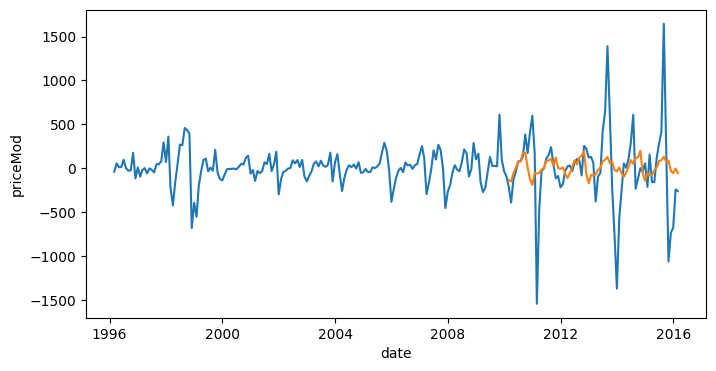

In [46]:
price.dropna()
# plt.figure(figsize=(15,5))
sns.lineplot(data=price,x=price.index,y='priceMod')
sns.lineplot(data=price,x=price.index,y='sarimaPredPrice')
plt.show()

In [47]:
mse = mean_squared_error(test_price['priceMod'], prediction)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Normalize the error metrics
test_range = test_price['priceMod'].max() - test_price['priceMod'].min()

normalized_rmse = rmse / test_range
print(f'norm Root Mean Squared Error: {normalized_rmse}')

Root Mean Squared Error: 448.54173878593224
norm Root Mean Squared Error: 0.14069350687929982


### Prophet for price

In [48]:
# Instantiate the Prophet model
model = Prophet()
diff_price.reset_index(inplace=True)
# Rename the columns to match Prophet's requirements
diff_price.columns = ['ds', 'y']
# Fit the model

train_data, test_data = train_test_split(diff_price, test_size=0.2, shuffle=False)  # Adjust test_size as needed

model.fit(train_data)

# Make predictions on the testing data
forecast = model.predict(test_data[['ds']])

00:57:51 - cmdstanpy - INFO - Chain [1] start processing
00:57:51 - cmdstanpy - INFO - Chain [1] done processing


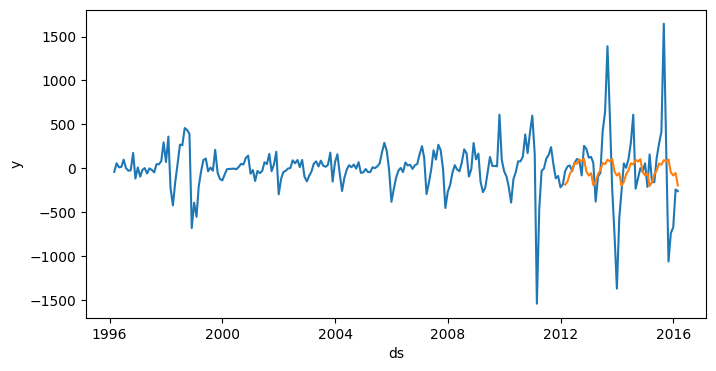

In [49]:
price.dropna()
# plt.figure(figsize=(15,5))
sns.lineplot(data=diff_price,x='ds',y='y')
sns.lineplot(data=forecast,x='ds',y='yhat')
plt.show()

In [50]:
# Calculate Mean Squared Error (MSE) as a measure of forecast accuracy
mse = mean_squared_error(test_data['y'], forecast['yhat'])

print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

test_range = test_data['y'].max() -test_data['y'].min()
normalized_rmse = rmse / test_range
print(f'norm Root Mean Squared Error: {normalized_rmse}')

Mean Squared Error: 225107.92260160708
Root Mean Squared Error: 474.4553957977579
norm Root Mean Squared Error: 0.15730445332557613


## Multivariate Time Series

In [62]:
# You can create a DataFrame like this:
data = pd.DataFrame({
    'quantity': monthly_mean.quantity,
    'price': monthly_mean.priceMod
})

In [68]:
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [69]:
# Assuming train and valid are your numpy arrays with the shape (time_steps, features)
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_valid = scaler.transform(valid)

# Function to create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Create sequences
seq_length = 10  # Define sequence length
x_train, y_train = create_sequences(scaled_train, seq_length)
x_valid, y_valid = create_sequences(scaled_valid, seq_length)

# Reshape input to be 3D [samples, time steps, features]
num_features = train.shape[1]  # Number of features
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], num_features))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], num_features))

In [82]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, num_features)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(Dense(32))
model.add(LSTM(units=50))
model.add(Dense(16))
model.add(Dense(8))  
model.add(Dense(num_features))  # Output layer with number of features
model.compile(optimizer='adam', loss='mean_squared_error')

In [83]:
# Train the Model
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/500
6/6 [==============================] - 4s 179ms/step - loss: 0.0505 - val_loss: 0.1687
Epoch 2/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0279 - val_loss: 0.1254
Epoch 3/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0223 - val_loss: 0.1489
Epoch 4/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0220 - val_loss: 0.1228
Epoch 5/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0211 - val_loss: 0.1121
Epoch 6/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0212 - val_loss: 0.1154
Epoch 7/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0204 - val_loss: 0.1203
Epoch 8/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0198 - val_loss: 0.1171
Epoch 9/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0196 - val_loss: 0.1151
Epoch 10/500
6/6 [==============================] - 0s 17ms/step - loss: 0.0200 - val_loss: 0.1204
Epoch 11/500
6/6 [

In [84]:
# Make Predictions
predictions = model.predict(x_valid)

2/2 [==============================] - 1s 4ms/step


In [85]:
# Rescale predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
valid_rescaled = scaler.inverse_transform(y_valid)

In [86]:
# Check RMSE and print it
for i in range(num_features):
    rmse = np.sqrt(mean_squared_error(valid_rescaled[:, i], predictions_rescaled[:, i]))
    print(f'RMSE value for feature {i+1} is: {rmse}')

RMSE value for feature 1 is: 19254.673958667834
RMSE value for feature 2 is: 805.7646998767553


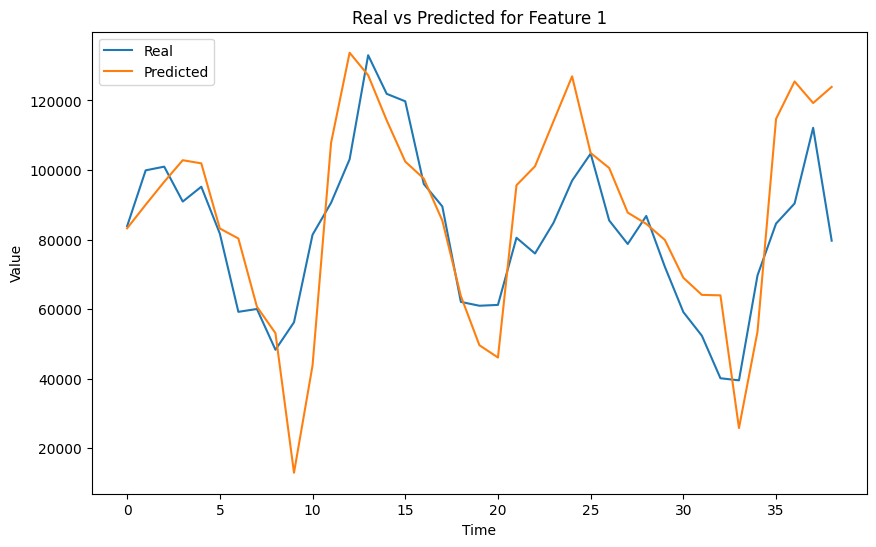

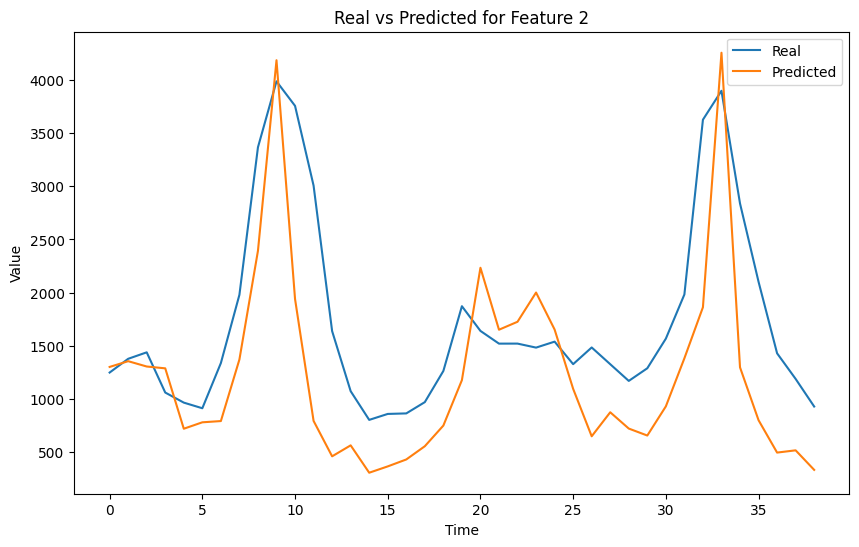

In [87]:
# Plot real vs predictions
for i in range(num_features):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_rescaled[:, i], label='Real')
    plt.plot(predictions_rescaled[:, i], label='Predicted')
    plt.title(f'Real vs Predicted for Feature {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
